<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/object-detection/Object%20Detection%20Inference%20With%20TF%20Hub%20And%20Detection%20Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

print(tf.__version__)

print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.7.0
The following GPU devices are available: 


## Loading the selected model from TensorFlow Hub

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
detector = hub.load(module_handle).signatures['default']


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Load Target Image

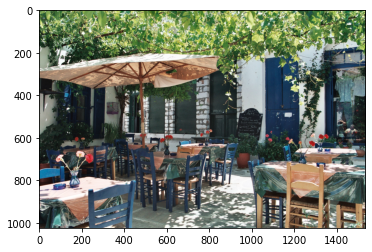

In [ ]:
import urllib
def download_image(url):
  import urllib.request
  urllib.request.urlretrieve(url, "/tmp/local-filename.jpg")
  return

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

url = 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg'
download_image(url)
iimg = load_img("/tmp/local-filename.jpg")
plt.imshow(iimg)


## Doing the inference

Run Detector with the downloaded image.

The Detector returns a dictionary which contains the following values:

- **detection_boxes**: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].
- **detection_class_entities**: a tf.string tensor of shape [N] containing detection class names as Freebase MIDs.
- **detection_class_names**: a tf.string tensor of shape [N] containing human-readable detection class names.
- **detection_class_labels**: a tf.int64 tensor of shape [N] with class indices.
- **detection_scores**: a tf.float32 tensor of shape [N] containing detection scores.



In [ ]:
def run_detector(detector, img):
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)
  detections = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(detections["detection_scores"]))
  print(type(detections))
  return detections
  
detections = run_detector(detector, iimg)

print('detections key names: {}'.format(detections.keys()))

Found 100 objects.
<class 'dict'>


####Print Detections Key Names

In [ ]:
for key in detections.keys():
  print(key)


detection_class_names
detection_class_labels
detection_scores
detection_class_entities
detection_boxes


##Helper Functions

Dunctions for display image with bounding boxes and text annotations

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def draw_bounding_box(image, ymin, xmin, ymax, xmax, color, thickness=3):
  draw = ImageDraw.Draw(image)
  draw.line([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin),
             (xmin, ymin)],
            width=thickness,
            fill=color)
  return image


def draw_text_on_bounding_box(image, ymin, xmin, color, display_str_list=()):
  draw = ImageDraw.Draw(image)
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",  25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  text_heights = [font.getsize(string)[1] for string in display_str_list]
  text_margin_factor = 0.05
  total_text_height = (1 + 2 * text_margin_factor) * sum(text_heights)
  
  if ymin > total_text_height:
    text_bottom = ymin
  else:
    text_bottom = ymin + total_text_height

  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    text_margin = np.ceil(text_margin_factor * text_height)
    draw.rectangle([(xmin, text_bottom - text_height - 2 * text_margin),
                    (xmin + text_width, text_bottom)],
                   fill=color)
    draw.text((xmin + text_margin, text_bottom - text_height - text_margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * text_margin
    return image

def annotate_detection(image_pil, box, class_name, score):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  im_width, im_height = image_pil.size
  ymin, xmin, ymax, xmax = tuple(box * [im_height, im_width, im_height, im_width] ) 
  colors = list(ImageColor.colormap.values())
  color = colors[hash(class_name) % len(colors)]

  image_pil = draw_bounding_box(image_pil,
                                    ymin, 
                                    xmin, 
                                    ymax, 
                                    xmax,
                                    color,
                                    thickness=4)
    
  display_str = "{}: {}%".format(class_name.decode("ascii"),
                                     int(100 * score))
    
  image_pil = draw_text_on_bounding_box(
                                  image_pil,
                                  ymin, 
                                  xmin,
                                  color,
                                  display_str_list=[display_str])

  return image_pil

def annotate_detections(image, boxes, class_names, scores, max_detections, min_score_thresh):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

  for idx, (box, class_name, score) in enumerate(zip(boxes, class_names, scores)):
    if idx > max_detections or scores < min_score_thresh:
      break
    image_pil = annotate_detection(image_pil, box, class_name, score)

  return image_pil


##Annotate Detections

Draw: 

- Bounding Boxes
- Categorized Class Names
- Detection Scores

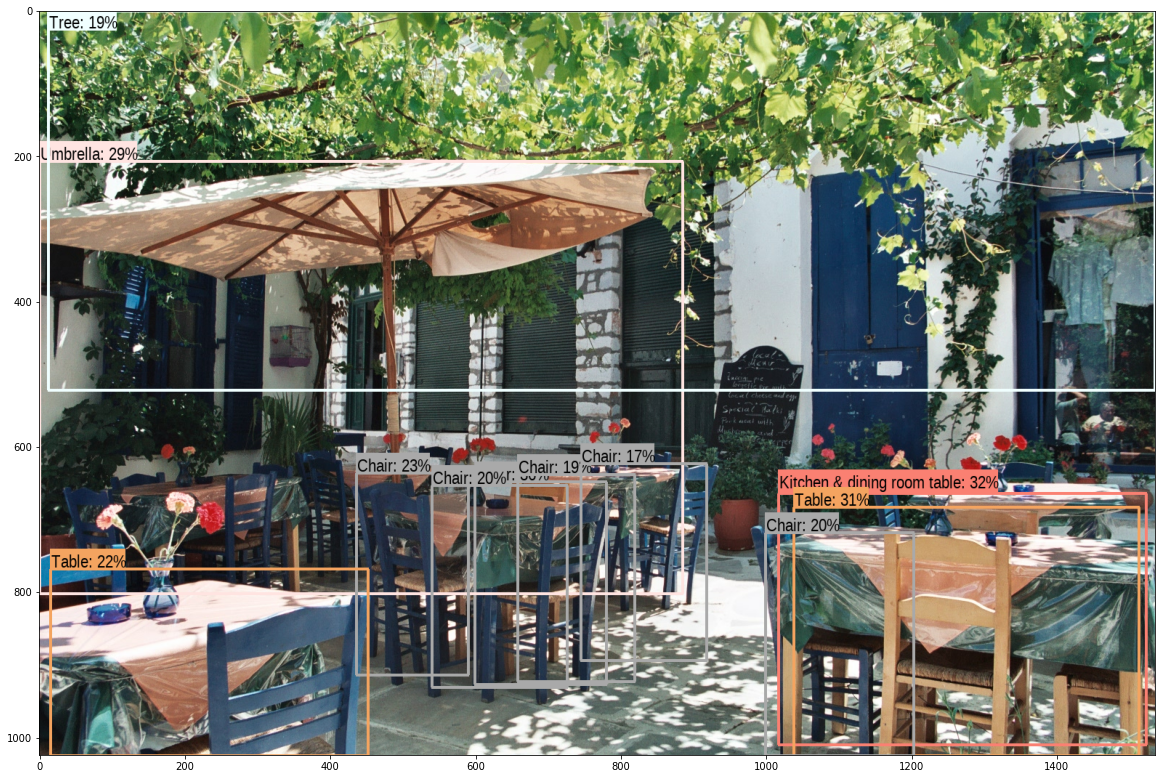

In [ ]:
min_score_thresh = 0.4
max_detections = 10
image_with_det_annotations = annotate_detections(
      iimg.numpy(), detections["detection_boxes"],
      detections["detection_class_entities"], detections["detection_scores"], max_detections, min_score_thresh)
display_image(image_with_det_annotations)

